In [1]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet  # ElasticNet 추가
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor  # MLP 추가
from sklearn.neighbors import KNeighborsRegressor  # KNN 추가
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor  # XGBoost
from lightgbm import LGBMRegressor  # LightGBM
from sklearn.svm import SVR  # SVR
import warnings

warnings.filterwarnings('ignore')

C:\Users\lhj52\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [3]:
# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

# data processing

In [4]:
train.head()

,ID,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
0,TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
1,TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
2,TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
3,TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
4,TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
 10  Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 644.7+ KB


In [6]:
train['Weight_Status'].value_counts()
train['Gender'].value_counts()

Gender
F    3769
M    3731
Name: count, dtype: int64

In [7]:
train.describe()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Age,Calories_Burned
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,104.033573,95.498133,5.248800,5.717600,165.361187,42.636000,89.373467
std,8.3553,1.412845,9.587331,0.556663,3.497315,33.308136,16.883188,62.817086
min,1.0000,98.800000,69.000000,4.000000,0.000000,79.400000,20.000000,1.000000
25%,8.0000,103.300000,88.000000,5.000000,3.000000,138.900000,28.000000,35.000000
50%,15.0000,104.400000,95.000000,5.000000,6.000000,163.100000,39.000000,77.000000
75%,23.0000,105.100000,103.000000,6.000000,9.000000,191.800000,56.000000,138.000000
max,30.0000,106.700000,128.000000,7.000000,12.000000,291.000000,79.000000,300.000000


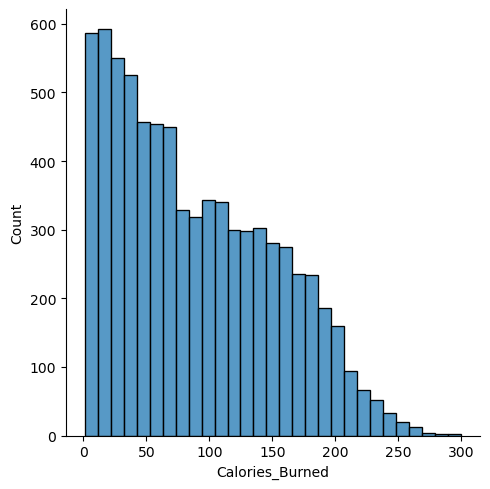

In [8]:

sns.displot(train['Calories_Burned'])
plt.show()

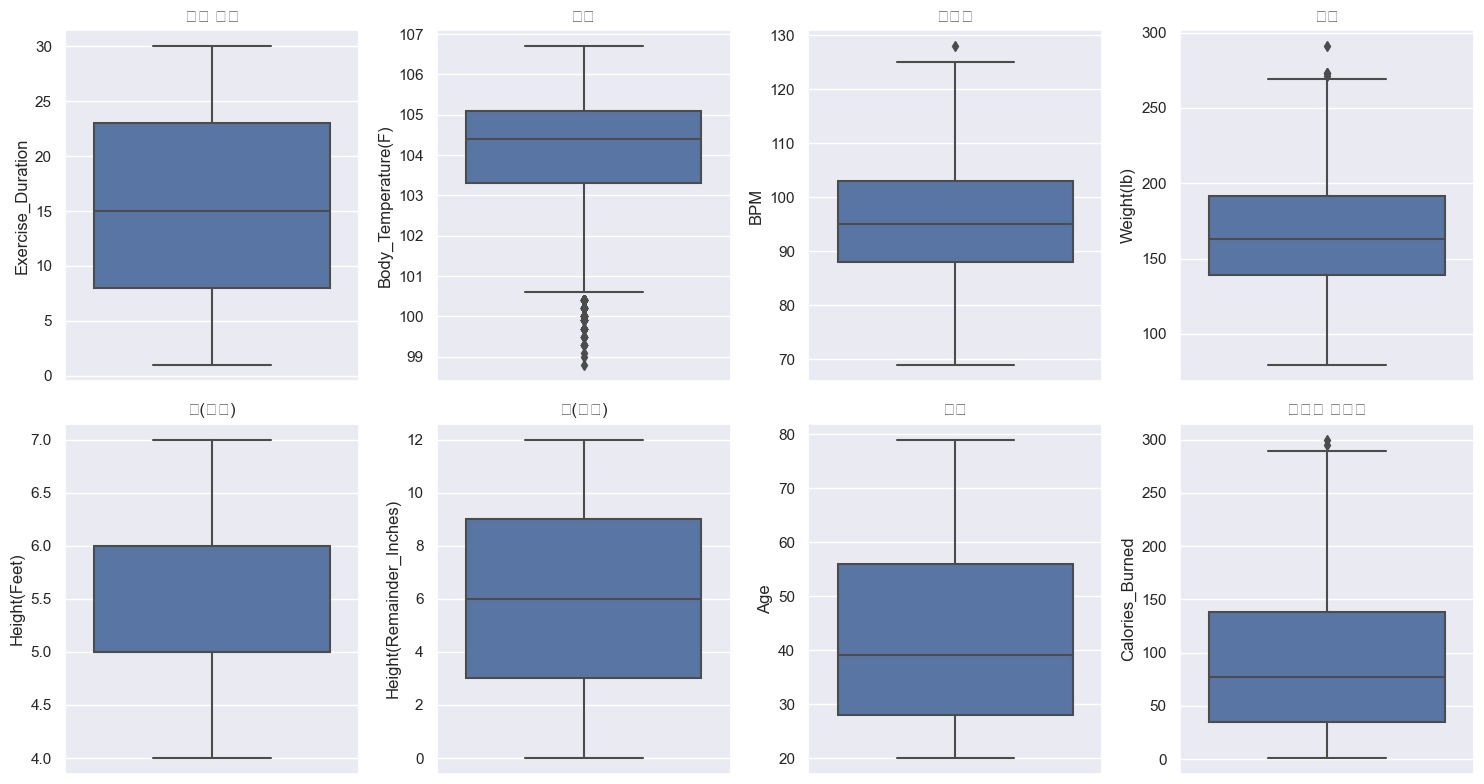

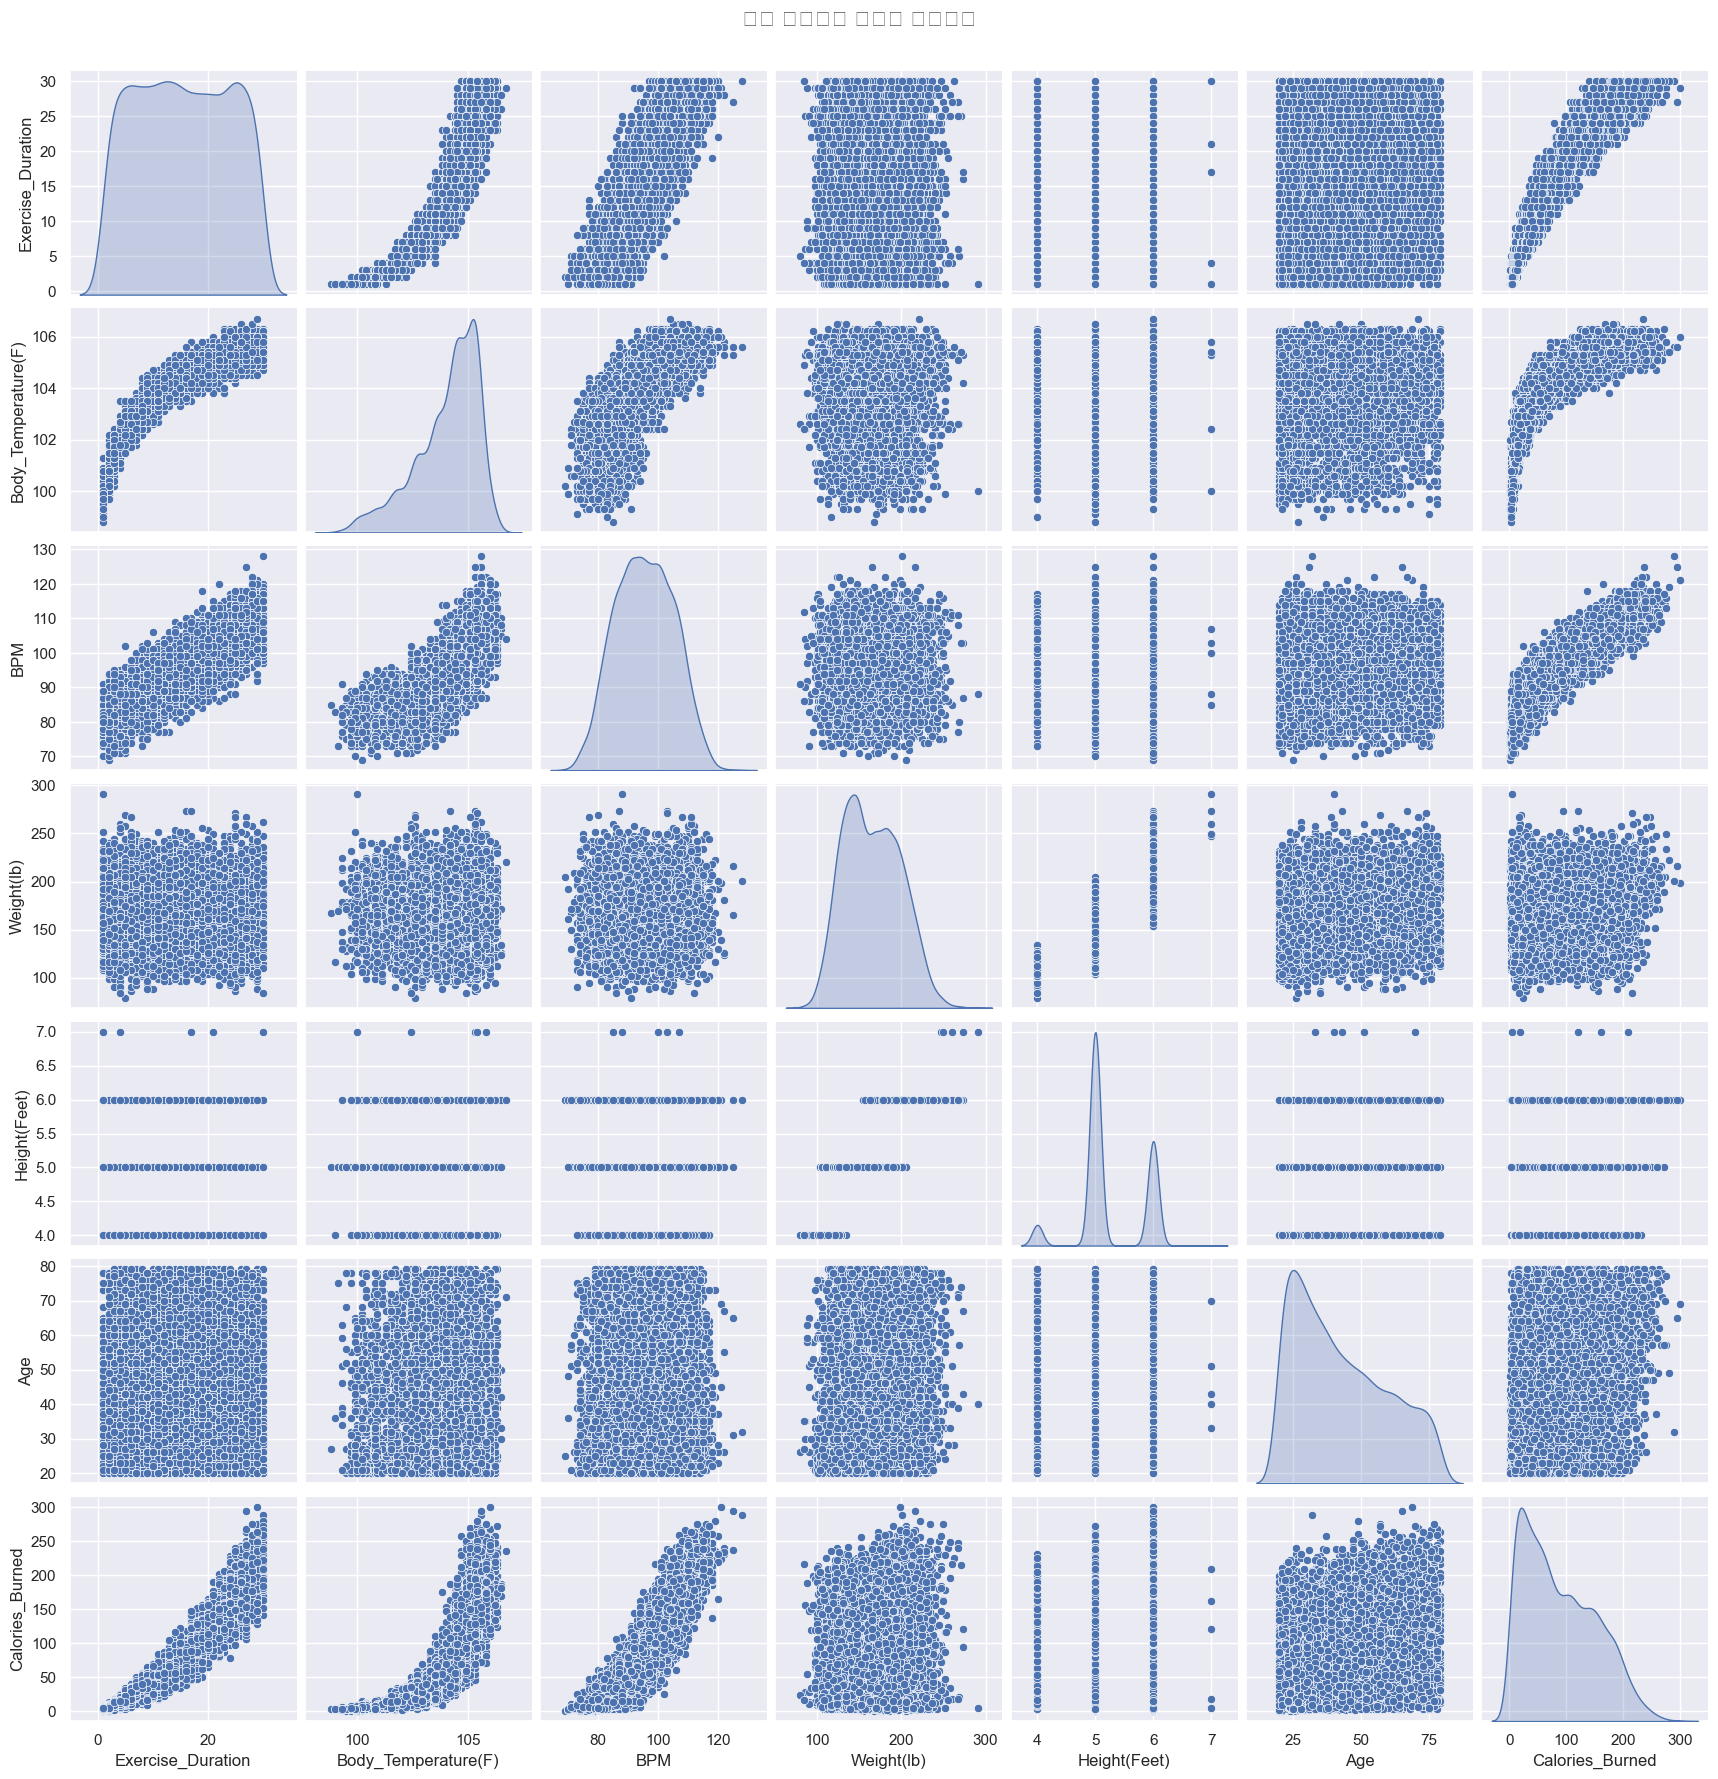

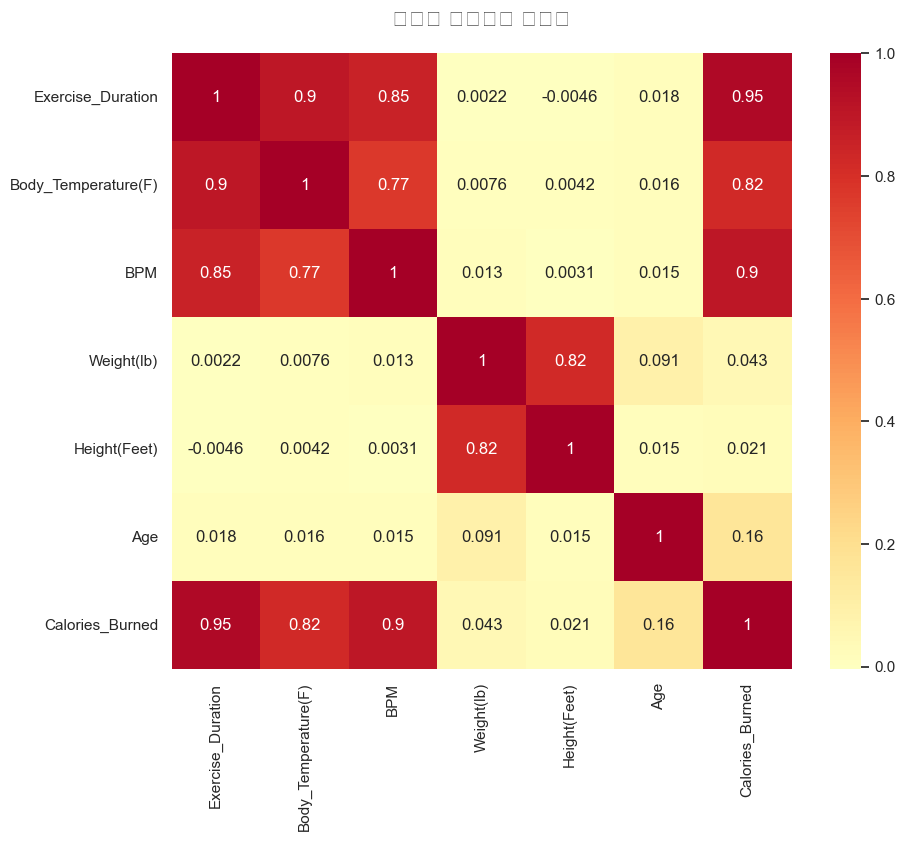

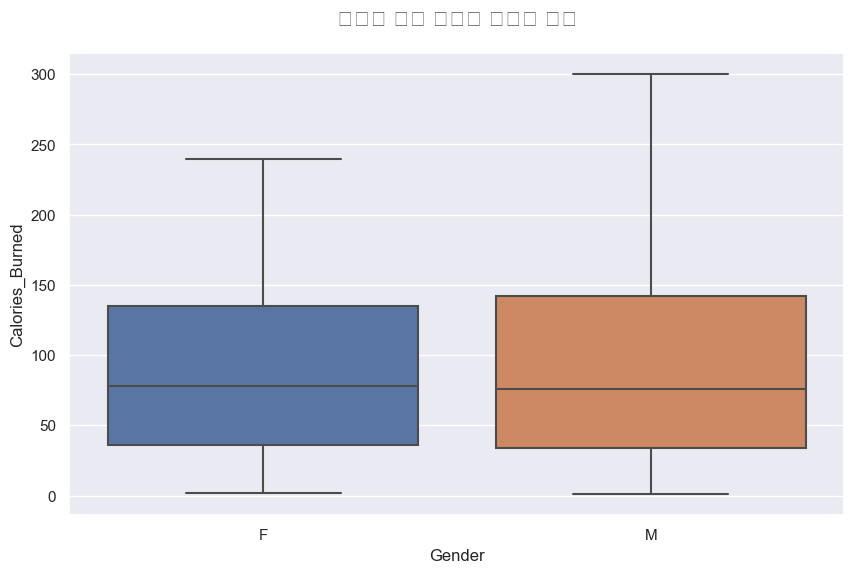

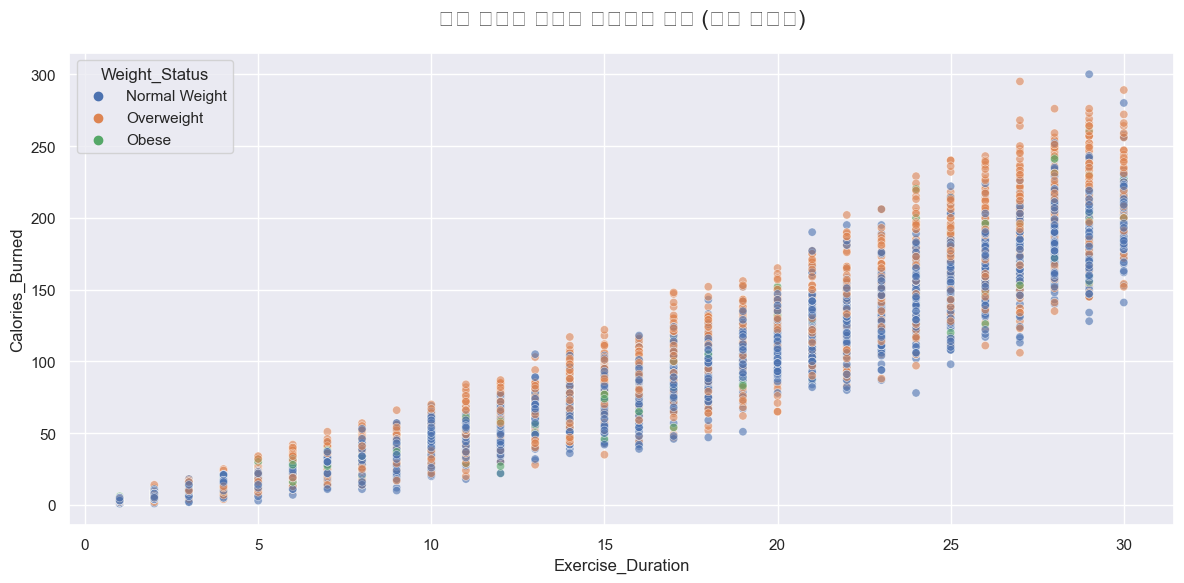


Exercise_Duration의 이상치 개수: 0
최소값: 1.00
최대값: 30.00
IQR: 15.00

Body_Temperature(F)의 이상치 개수: 195
최소값: 98.80
최대값: 106.70
IQR: 1.80

BPM의 이상치 개수: 1
최소값: 69.00
최대값: 128.00
IQR: 15.00

Weight(lb)의 이상치 개수: 4
최소값: 79.40
최대값: 291.00
IQR: 52.90

Height(Feet)의 이상치 개수: 0
최소값: 4.00
최대값: 7.00
IQR: 1.00

Age의 이상치 개수: 0
최소값: 20.00
최대값: 79.00
IQR: 28.00

Calories_Burned의 이상치 개수: 2
최소값: 1.00
최대값: 300.00
IQR: 103.00


In [9]:
# seaborn 스타일 설정
sns.set_theme()  # 새로운 seaborn 스타일 적용 방식

# 1. 수치형 변수들의 박스플롯
numeric_cols = ['Exercise_Duration', 'Body_Temperature(F)', 'BPM',
               'Weight(lb)', 'Height(Feet)', 'Age', 'Calories_Burned']

plt.figure(figsize=(15, 8))
plt.subplot(2, 4, 1)
sns.boxplot(y=train['Exercise_Duration'])
plt.title('운동 시간')

plt.subplot(2, 4, 2)
sns.boxplot(y=train['Body_Temperature(F)'])
plt.title('체온')

plt.subplot(2, 4, 3)
sns.boxplot(y=train['BPM'])
plt.title('심박수')

plt.subplot(2, 4, 4)
sns.boxplot(y=train['Weight(lb)'])
plt.title('체중')

plt.subplot(2, 4, 5)
sns.boxplot(y=train['Height(Feet)'])
plt.title('키(피트)')

plt.subplot(2, 4, 6)
sns.boxplot(y=train['Height(Remainder_Inches)'])
plt.title('키(인치)')

plt.subplot(2, 4, 7)
sns.boxplot(y=train['Age'])
plt.title('나이')

plt.subplot(2, 4, 8)
sns.boxplot(y=train['Calories_Burned'])
plt.title('칼로리 소모량')

plt.tight_layout()
plt.show()

# 2. 수치형 변수들의 분포 및 상관관계
sns.pairplot(data=train[['Exercise_Duration', 'Body_Temperature(F)', 'BPM',
                        'Weight(lb)', 'Height(Feet)', 'Age', 'Calories_Burned']],
             diag_kind='kde')
plt.suptitle('주요 변수들의 산점도 매트릭스', y=1.02, fontsize=16)

# 3. 히트맵으로 상관관계 시각화
plt.figure(figsize=(10, 8))
correlation = train[['Exercise_Duration', 'Body_Temperature(F)', 'BPM',
                    'Weight(lb)', 'Height(Feet)', 'Age', 'Calories_Burned']].corr()
sns.heatmap(correlation, annot=True, cmap='RdYlBu_r', center=0)
plt.title('변수간 상관관계 히트맵', pad=20, fontsize=16)

# 4. 성별에 따른 칼로리 소모량
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Calories_Burned', data=train)
plt.title('성별에 따른 칼로리 소모량 분포', pad=20, fontsize=16)

# 5. 운동 시간과 칼로리 소모량의 관계 (체중 상태별)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='Exercise_Duration', y='Calories_Burned',
                hue='Weight_Status', alpha=0.6)
plt.title('운동 시간과 칼로리 소모량의 관계 (체중 상태별)', pad=20, fontsize=16)

plt.tight_layout()
plt.show()

# 이상치 통계 출력
for col in numeric_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = len(train[(train[col] < Q1 - 1.5 * IQR) | (train[col] > Q3 + 1.5 * IQR)])
    print(f"\n{col}의 이상치 개수: {outlier_count}")
    print(f"최소값: {train[col].min():.2f}")
    print(f"최대값: {train[col].max():.2f}")
    print(f"IQR: {IQR:.2f}")

In [10]:
# 1. 수치형 변수들의 왜도와 첨도 확인
numeric_features = ['Exercise_Duration', 'Body_Temperature(F)', 'BPM',
                   'Weight(lb)', 'Height(Feet)', 'Age']

# 왜도와 첨도 계산
skew_kurt = pd.DataFrame({
    'Skewness': train[numeric_features].skew(),
    'Kurtosis': train[numeric_features].kurtosis()
}).round(3)

print("왜도와 첨도:")
print(skew_kurt.sort_values(['Kurtosis'], ascending=False))

# 로그 변환이 필요한 변수 선정
# |왜도| > 1 또는 |첨도| > 3
log_features = skew_kurt[
    (abs(skew_kurt['Skewness']) > 1) |
    (abs(skew_kurt['Kurtosis']) > 3)
].index.tolist()

print("\n로그 변환이 필요한 변수들:", log_features)

# 만약 로그 변환이 필요한 변수가 있다면, 변환 전후 비교
if log_features:
    for feature in log_features:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        sns.histplot(data=train, x=feature, kde=True)
        plt.title(f'Original {feature}\nSkew: {skew_kurt.loc[feature, "Skewness"]:.3f}, Kurt: {skew_kurt.loc[feature, "Kurtosis"]:.3f}')

        plt.subplot(1, 2, 2)
        transformed_data = np.log1p(train[feature])
        sns.histplot(x=transformed_data, kde=True)
        plt.title(f'Log Transformed {feature}\nSkew: {transformed_data.skew():.3f}, Kurt: {transformed_data.kurtosis():.3f}')

        plt.tight_layout()
        plt.show()

왜도와 첨도:
                     Skewness  Kurtosis
Body_Temperature(F)    -0.972     0.440
Height(Feet)            0.036    -0.346
BPM                     0.024    -0.660
Weight(lb)              0.224    -0.678
Age                     0.496    -0.919
Exercise_Duration       0.012    -1.195

로그 변환이 필요한 변수들: []


In [11]:
ordinal_features = ['Weight_Status', 'Gender']
for feature in ordinal_features:
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[feature] = le.transform(test[feature])

In [12]:
train_x = train.drop(['ID', 'Calories_Burned', 'Weight_Status', 'Height(Remainder_Inches)', 'Height(Feet)'], axis=1)
train_y = train['Calories_Burned']
test_x = test.drop(['ID', 'Weight_Status', 'Height(Remainder_Inches)', 'Height(Feet)'], axis=1)

poly = PolynomialFeatures(degree=3)  # 모든 고차항 생성
train_poly = poly.fit_transform(train_x)
test_poly = poly.transform(test_x)

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=40)
train_poly = selector.fit_transform(train_poly, train_y)
test_poly = selector.transform(test_poly)

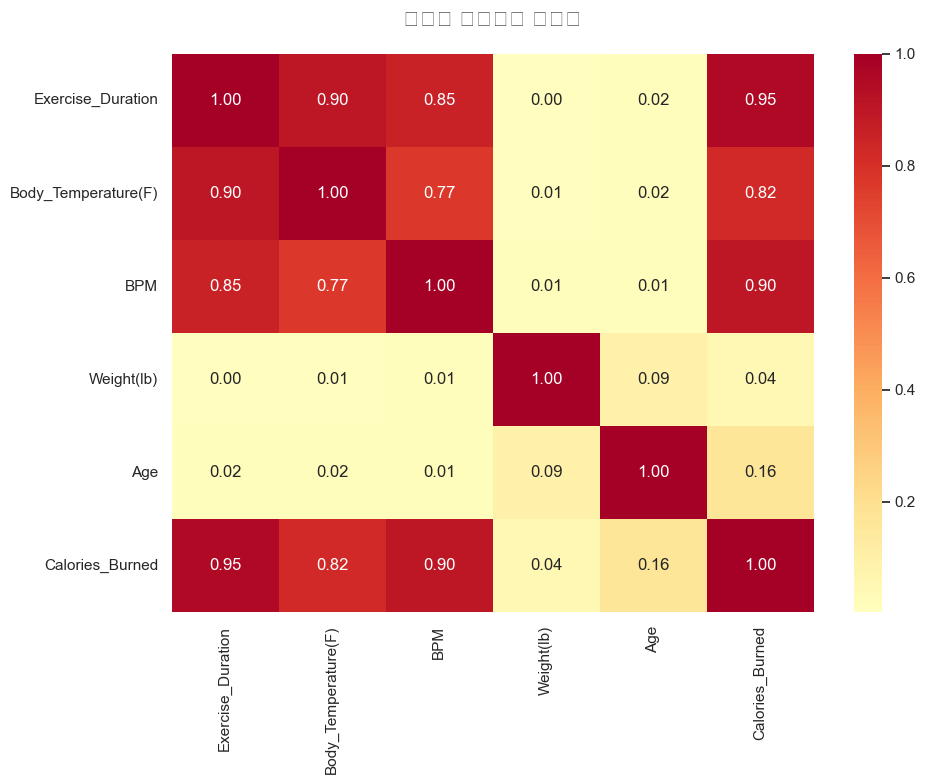


칼로리 소모량과의 상관관계:
Exercise_Duration      0.954783
BPM                    0.899900
Body_Temperature(F)    0.824379
Age                    0.159624
Weight(lb)             0.042568
Name: Calories_Burned, dtype: float64


In [13]:
# # 전처리 후 상관관계 히트맵
plt.figure(figsize=(10, 8))
numeric_columns = ['Exercise_Duration', 'Body_Temperature(F)', 'BPM',
                  'Weight(lb)', 'Age', 'Calories_Burned']
correlation = train[numeric_columns].corr()

sns.heatmap(correlation,
            annot=True,
            fmt='.2f',
            cmap='RdYlBu_r',
            center=0)

plt.title('변수간 상관관계 히트맵', pad=20, fontsize=16)
plt.tight_layout()
plt.show()

# 칼로리 소모량과의 상관관계 출력
correlations = correlation['Calories_Burned'].sort_values(ascending=False)
print("\n칼로리 소모량과의 상관관계:")
print(correlations[correlations.index != 'Calories_Burned'])

In [14]:
# 스태킹 모델 구성
base_models = [
    ('linear', LinearRegression()),
    ('ridge', Ridge()),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),  # XGBoost 추가
    ('lgbm', LGBMRegressor(n_estimators=100, random_state=42)),  # LightGBM 추가
    ('svr', SVR(kernel='rbf')),  # SVR 추가
    ('elastic', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)),  # ElasticNet 추가
    ('mlp', MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)),  # MLP 추가
    ('knn', KNeighborsRegressor(n_neighbors=5))  # KNN 추가
]

stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0)  # 최종 추정기로 Ridge 사용
)

In [15]:
# 교차 검증
cv_scores = np.sqrt(-cross_val_score(stacking, train_poly, train_y, cv=5, scoring='neg_mean_squared_error'))
print(f"Cross-validation RMSE: {cv_scores.mean()}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7542
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 40
[LightGBM] [Info] Start training from score 89.411500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7539
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 40
[LightGBM] [Info] Start training from score 89.167292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7542
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 40
[LightGBM] [Info] Start trai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7536
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 40
[LightGBM] [Info] Start training from score 89.250167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7529
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 40
[LightGBM] [Info] Start training from score 89.454583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7531
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 40
[LightGBM] [Info] Start trai

In [16]:
# 학습 및 검증
X_train, X_val, y_train, y_val = train_test_split(train_poly, train_y, test_size=0.1, random_state=42, shuffle=True)
stacking.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7544
[LightGBM] [Info] Number of data points in the train set: 6750, number of used features: 40
[LightGBM] [Info] Start training from score 89.585926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7525
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 40
[LightGBM] [Info] Start training from score 89.704444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7533
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 40
[LightGBM] [Info] Start trai

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('ridge', Ridge()),
                              ('rf',
                               RandomForestRegressor(n_estimators=50,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=Non...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgbm', LGBMRegressor(random_state=42)),
                              ('svr', SVR()),
                              ('elastic', ElasticNet(random_state=42)),
                              ('mlp',
                               MLPRegressor(hidden_layer_sizes=(50, 50),
                                            max_iter=1000, random_state=42)),
                              ('knn', KNeighborsRegressor())],
                  final_estimator=Ridge())

In [17]:
# 검증 성능 평가
y_pred = stacking.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")

Validation RMSE: 0.28920452455217543


In [18]:
# 테스트 데이터 예측 및 제출 파일 생성
test_preds = stacking.predict(test_poly)
sample_submission['Calories_Burned'] = np.round(test_preds)
sample_submission.to_csv('submission_01.csv', index=True)

In [19]:
import pickle

# final_model.ipynb에서 모델 저장 시
model_data = {
    'model': stacking,
    'poly': poly,
    'selector': selector
}

with open('final_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)


print("스태킹 모델 학습 및 저장 완료!")

스태킹 모델 학습 및 저장 완료!
